# Assignment 2: Large Language Models for Text Classification

### CS 410/510 Large Language Models Fall 2024

#### Greg Witt

## Load Dataset

**Install Dependencies**

In [126]:
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
85077.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from datasets import load_dataset
import random

# load the training set of tweets
ds_train = load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english", split="train")
# the dataset labels {0 : negative, 1: neutral, 2: positive }
print(f"""tweet_sentiment_multilingual training dataset: 
    -----------------------------------------
        {ds_train} 
    """)
random_tweet_index = random.randint(0,1839)
print(f"""
    Random Tweet:
    {ds_train['text'][random_tweet_index]}

    Label: 
    {ds_train['label'][random_tweet_index] }
""")


tweet_sentiment_multilingual training dataset: 
    -----------------------------------------
        Dataset({
    features: ['text', 'label'],
    num_rows: 1839
}) 
    

    Random Tweet:
    @user went to get vip for February 11th show and you're sold out my heart is broken I can't meet you with my big brother 

    Label: 
    0



In [5]:

# load the training set of tweets
ds_validation = load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english", split="validation")
# the dataset labels {0 : negative, 1: neutral, 2: positive }
print(f"""tweet_sentiment_multilingual validation set: 
    -----------------------------------------
        {ds_validation}
    """)
random_tweet_index = random.randint(0,324)
print(f"""
    Random Tweet:
    {ds_validation['text'][random_tweet_index]}

    Label: 
    {ds_validation['label'][random_tweet_index] }
""")


tweet_sentiment_multilingual validation set: 
    -----------------------------------------
        Dataset({
    features: ['text', 'label'],
    num_rows: 324
})
    

    Random Tweet:
    @user digi was on the 18th but i didn't go but im going to slaybells 

    Label: 
    2



## Load the Models

**Load Dependencies**

In [ ]:
!pip install transformers torch

#### [Lama 3.2 1B](https://huggingface.co/meta-llama/Llama-3.2-1B) 



In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

llama_3_2_1B = "meta-llama/Llama-3.2-1B"

llama_3_2_1B_tokenizer = AutoTokenizer.from_pretrained(llama_3_2_1B)

llama_3_2_1B_model = AutoModelForCausalLM.from_pretrained(llama_3_2_1B)



In [35]:
# tokenizer assigns the probability 
"Text: I hate it! \nSentiment (positive, negative, neutral):"

prompt_approach_two = f"""{tweet} Sentiment: """

In [36]:
# Text to classify
text = "Your text to classify here."

# Tokenize the text
inputs = tokenizer(text, return_tensors="pt")

# Get model predictions
outputs = model(**inputs)
logits = outputs.logits

# Determine the predicted class
predicted_class = torch.argmax(logits, dim=1).item()


NameError: name 'tokenizer' is not defined

In [ ]:
with torch.no_grad():
    outputs = model(**inputs, labels=inputs["input_ids"])
    log_probs = torch.nn.functional.log_softmax(outputs.logits, dim=-1)

In [20]:
Experiment #2 

1 prompt  2 positive , 2 negative, 2 neutral k = 2 {tweet} : Sentiment {?} =>

NameError: name 'Experiment' is not defined

In [23]:
# 3 
google_this if needed.
chain_of_thought = "think about this step by step this sound positive, negative, neurtal?\n"
f"{chain_of_thought} {tweet}"

# emotion based: pull on compassion strings.
"I need this for my job: classify as negative, positive or neutral"

SyntaxError: expected 'else' after 'if' expression (2972846960.py, line 2)

#### [Phi 3.5 Instruct]()

**Load The Model**

In [101]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# model name
phi_model = "microsoft/Phi-3.5-mini-instruct"

phi_3_5_tokenizer = AutoTokenizer.from_pretrained(phi_model)

phi_3_5_model = AutoModelForCausalLM.from_pretrained(phi_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Experiments 1: Zero-Shot Inference 

### Create Prompt Iteration Function

In [6]:
prompt_template = "\"{}\" \n Sentiment (positive (2), negative (0), neutral (1)): "

### Llama 3.3 1B: Zero Shot Inference

In [7]:
# encode possible labels 
positive_id = llama_3_2_1B_tokenizer.encode("positive", add_special_tokens=False)[0]
negative_id = llama_3_2_1B_tokenizer.encode("negative", add_special_tokens=False)[0]
neutral_id = llama_3_2_1B_tokenizer.encode("neutral", add_special_tokens=False)[0]



31587
43324
60668


In [178]:
import re

def sanitize_tweet(tweet):
    sanitized_tweet = re.sub(r"(\@\w+ | \#\w+)","", tweet)
    return sanitized_tweet

In [168]:

# sanitize tweets
# removes user tags
tweet_user = "@user @user I think after Charlie Hebdo the French did NOT react as the US did after 9/11. But they may do this time around. "

user_swap = re.sub(r'\@\w+',"", tweet_user)

sanitize_tweet(tweet_user)

# hash tag heavy tweet
hash_tag_tweet = "Beautiful Bouquet with our Beautiful Bentley #bride #groom #wedding #wednesday #weddingcars #love   #Repost..."

tag_swap = re.sub(r'\#\w+',"", hash_tag_tweet)

sanitize_tweet(hash_tag_tweet)



I think after Charlie Hebdo the French did NOT react as the US did after 9/11. But they may do this time around. 
Beautiful Bouquet with our Beautiful Bentley  ...


### Approach 1: Parse Single Token Response

This approach prompts the model in question for a sentiment classification of a tweet, the **[AutoModelForCausalLM's](https://huggingface.co/docs/transformers/v4.46.0/en/main_classes/text_generation#transformers.GenerationMixin.generate)** `mode.generate()` call is invoked in order to ellicit a response to our provided prompt. the `generate()` method can be provided with several parameters. this approach modifies the **[GenerationConfiguration](https://huggingface.co/docs/transformers/v4.46.0/en/main_classes/text_generation#transformers.GenerationConfig)** allowing for certain constraints. for this approach we ensure that the `max_new_tokens=1` and `pad_token_id` is set to ensure there is only one token generated from the model. This token is then used to represent our model's response to the sentiment prompt. 

This approach can work but there are risks associated with this method, because these models haven't gone through any **fine-tuning**. Meaning their lack of training hasn't prepared them to for **sentiment classification**, meaning instead of receiving a "0" for neutral, "1" for negative, or "2" for positive there could be other undesirable tokens coming back. To handle this I created a `santize_response()` method that will take the generated tokens and determine if the response can be related to a sentiment classification.

In [35]:
import re

def santize_response(response_token):
    if re.search(r'\d', response_token):
        return int(response_token)
    else:
        return 0

    

In [36]:
import numpy as np

# hold the ground_truths
ground_truths = []
# hold the sentiment_predictions
sentiment_preds = []

# iterate through the validation set
for tweet, label in zip(ds_validation['text'], ds_validation['label']):
    prompt_tweet = tweet
    gt_label = label
    # combine the prompt
    prompt = prompt_template.format(prompt_tweet)
    
    # generate the response
    prompt_ids = llama_3_2_1B_tokenizer.encode(prompt, return_tensors="pt")

    outputs = llama_3_2_1B_model.generate(
                        prompt_ids,
                        pad_token_id=llama_3_2_1B_tokenizer.eos_token_id,
                        max_new_tokens=1
                    )
    
    # get the response tokens from the model
    generated_tokens = outputs[-1]
    
    generated_response = llama_3_2_1B_tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # pass the generated_response to a sanitizer that determines if the response is valid
    sentiment_resp = santize_response(generated_response[-1])
    
    # Responses being compared to the Ground_Truth Labels
    # print(f"Generated Response: {sentiment_resp}")
    # print(f"Ground Truth: {gt_label}")

    ground_truths.append(gt_label)
    sentiment_preds.append(sentiment_resp)

ground_truths = np.asarray(ground_truths)
sentiment_preds = np.asarray(sentiment_preds)


### Build Classification Report 

**Import Python Libraries**

In [ ]:
pip install scikit-learn matplotlib

In [37]:
from sklearn.metrics import classification_report

print(classification_report(ground_truths, sentiment_preds))

              precision    recall  f1-score   support

           0       0.41      0.61      0.49       108
           1       0.43      0.31      0.36       108
           2       0.39      0.31      0.34       108

    accuracy                           0.41       324
   macro avg       0.41      0.41      0.40       324
weighted avg       0.41      0.41      0.40       324



### Build Confusion Matrix

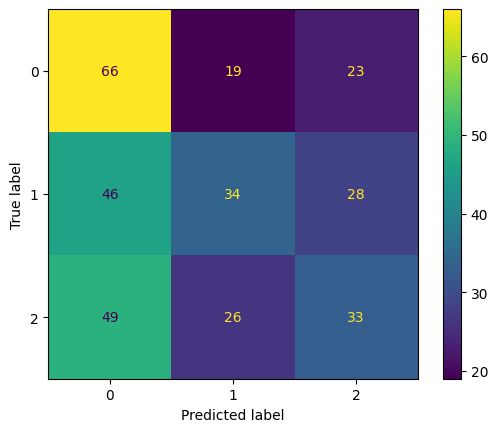

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(ground_truths, sentiment_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

### Approach 2: Use Logits to Determine Text Sentiment

In [170]:
sentiment_ids = {}
# encode possible labels 
sentiment_ids["positive"] = llama_3_2_1B_tokenizer.encode("positive", add_special_tokens=False)[0]
sentiment_ids["negative"] = llama_3_2_1B_tokenizer.encode("negative", add_special_tokens=False)[0]
sentiment_ids["neutral"] = llama_3_2_1B_tokenizer.encode("neutral", add_special_tokens=False)[0]

print(sentiment_ids)


{'positive': 31587, 'negative': 43324, 'neutral': 60668}


In [155]:
for sentiment in sentiment_ids:
    print(f"Sentiment: {sentiment}")
    print(f"Sentiment_ID: {sentiment_ids[sentiment]}")

Sentiment: positive
Sentiment_ID: 31587
Sentiment: negative
Sentiment_ID: 43324
Sentiment: neutral
Sentiment_ID: 60668


In [ ]:

# # iterate through the validation set
for tweet, label in zip(ds_validation['text'], ds_validation['label']):
    prompt_tweet = sanitize_tweet(tweet=tweet)
    print(f"Prompt_tweet: {prompt_tweet}")
    gt_label = label
    # combine the prompt
    prompt = prompt_template.format(prompt_tweet)
    
    prompt_ids = llama_3_2_1B_tokenizer.encode(prompt, return_tensors="pt")

    with torch.no_grad():
        outputs = llama_3_2_1B_model(prompt_ids)
    
        # get the output logits
        logits = outputs.logits

    
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

    # build a list of the sentiment options and the probability per sentiment
    tweet_sentiment_probabilities = {}

    for sentiment in sentiment_ids:
        tweet_sentiment_probabilities[sentiment] = log_probs[0, -1, sentiment_ids[sentiment]].item()
    
    
    max_sentiment = max(tweet_sentiment_probabilities, key=tweet_sentiment_probabilities.get)
    print(tweet_sentiment_probabilities)
    print(max_sentiment)
    
    print("-----------------------------")
    print(f"Tweet Prompt: {prompt}")
    print(f"Ground Truth: {gt_label}")
    print(f"Predicted Sentiment: {max_sentiment}")
    print("-----------------------------")

